In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import zscore
from scipy import stats
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint, LinearConstraint

from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Defining constants and working out save directories

In [35]:
import datetime
import os

year = datetime.date.today().year
month = datetime.date.today().month
base_figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(base_figs_dir):
    os.makedirs(base_figs_dir)

In [36]:
# data_tag = 'ecoli_full'
# data_tag = 'ecoli_sparse'
data_tag = 'scer_rna'
# data_tag = 'scer_prot'
save_figs = False
if save_figs:
    base_figs_dir += '/{}'.format(data_tag)
    if not os.path.exists(base_figs_dir):
        os.makedirs(base_figs_dir)

In [38]:
metric = 'CAI'
# metric = 'tAI'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'

if save_figs:
    figs_dir = base_figs_dir + '/{}'.format(metric)
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Import data

There are four main data tables to import / wrangle with. 

**First: gene-specific measurements (*i.e.* codon usage biases, predominantly)**

In [39]:
if data_tag in ['ecoli_full', 'ecoli_sparse']:
    full_df = pd.read_csv('../Data/ecoli_info/current_ecoli_master_table.tsv', sep='\t', index_col=0)
elif data_tag in ['scer_rna', 'scer_prot']:
    full_df = pd.read_csv('../Data/scer_info/current_scer_master_table.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(full_df.shape)
full_df = full_df[full_df[metric].isnull()==False]
print(full_df.shape)
full_df.head()

(5451, 12)
(5398, 12)


,gene,start_loc,stop_loc,strand,cds_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,CAI,tAI
locus_tag,,,,,,,,,,,,
CENPK1137D_4927,Gdh3p,31625.0,32998.0,+,ATGACAAGCGAACCAGAGTTTCAGCAGGCTTACGATGAGATCGTTT...,1374,True,0.485444,1.077532,0.089819,0.166896,0.414135
CENPK1137D_4938,Bdh2p,33506.0,34759.0,+,ATGAGAGCCTTAGCGTATTTCGGTAAAGGTAACATCAGATTCACCA...,1254,True,0.484848,0.559819,0.101853,0.146111,0.374852
CENPK1137D_4949,Bdh1p,35211.0,36359.0,+,ATGAGAGCTTTGGCATATTTCAAGAAGGGTGATATTCACTTCACTA...,1149,True,0.449956,1.741424,0.105991,0.239300,0.408900
CENPK1137D_4960,Ecm1p,36565.0,37203.0,+,ATGTGGGAACAAAGACGACAAAAGGTAGTTTTTTCCTTGACTATAC...,639,True,0.403756,0.997815,0.136281,0.180668,0.399201
CENPK1137D_4971,Cne1p,37520.0,39028.0,+,ATGAAATTTTCTGCGTATTTATGGTGGCTGTTTTTGAATCTAGCGT...,1509,True,0.433400,0.164382,0.050166,0.126947,0.323906


**Next: meta-data related to experiments / growth conditions**

In [40]:
if data_tag == 'ecoli_full':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(meta_df.shape)
meta_df.head()

(14, 14)


,Sample,Nitrogen source,dilution rate (/h),glucose.H2O concentration (g/L),nitrogen source concentration (g/L),limiting nutrient,C/N ratio,experiment subset,extra notes,Simple_sample_id,total RNA content (g/gDW),total protein content (g/gDW),Doubling_time,Growth Rate (1/hr)
0,1,NH4,0.05,7.5,0.5,N,30,GR,NaN,NH4_0.05_7.5_0.5,0.024169,0.261477,13.862944,0.05
3,4,NH4,0.10,7.5,5.0,C,3,NM,NaN,NH4_0.1_7.5_5.0,0.050000,0.358024,6.931472,0.10
6,7,NH4,0.10,7.5,0.5,N,30,"GR, NM",NaN,NH4_0.1_7.5_0.5,0.025297,0.225573,6.931472,0.10
9,10,NH4,0.13,7.5,0.5,N,30,GR,NaN,NH4_0.13_7.5_0.5,0.025831,0.275686,5.331901,0.13
12,13,NH4,0.18,7.5,0.5,N,30,GR,NaN,NH4_0.18_7.5_0.5,0.038539,0.286470,3.850818,0.18


**Next: condition-specific expression information**

In [41]:
if data_tag == 'ecoli_full':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_df.shape)
exp_df.head()

(3127, 14)


,NH4_0.05_7.5_0.5,NH4_0.1_7.5_5.0,NH4_0.1_7.5_0.5,NH4_0.13_7.5_0.5,NH4_0.18_7.5_0.5,NH4_0.3_7.5_0.5,NH4_0.35_7.5_0.5,Gln_0.1_7.5_5.53,Gln_0.1_1.21_5.53,Gln_0.1_6.87_0.55,Phe_0.1_7.5_12.35,Phe_0.1_7.5_1.24,Ile_0.1_7.5_9.81,Ile_0.1_7.5_0.98
Gene,,,,,,,,,,,,,,
SAL1,-9.529879,-9.462814,-9.358983,-9.349310,-9.222958,-9.351982,-9.339676,-9.418705,-9.529775,-9.331296,-9.294119,-9.299223,-9.317947,-9.363821
CET1,-9.169022,-9.139245,-9.078706,-9.031129,-9.071170,-9.227227,-9.302235,-9.106038,-9.220858,-9.136797,-9.276800,-9.180333,-9.150939,-9.142975
FOB1,-9.545055,-9.351033,-9.294461,-9.243162,-9.149694,-9.159748,-9.130156,-9.370800,-9.551954,-9.412692,-9.515242,-9.376876,-9.266782,-9.382779
RPS9A,-8.067467,-7.485624,-7.452787,-7.326448,-7.246923,-7.158720,-7.136058,-7.483618,-7.766808,-7.592273,-7.685154,-7.645901,-7.438962,-7.538191
COQ4,-8.303525,-8.475349,-8.614872,-8.736973,-8.886612,-9.258626,-9.339141,-8.471156,-8.456111,-8.633659,-8.572922,-8.657927,-8.696813,-8.607754


**Finally: expression summary statistics calculated from the condition-specific expression matrices**

In [42]:
if data_tag == 'ecoli_full':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary.tsv', sep='\t', index_col=0)
elif data_tag == 'ecoli_sparse':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_SPARSE.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_rna':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_RNA.tsv', sep='\t', index_col=0)
elif data_tag == 'scer_prot':
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_scer_PROTEIN.tsv', sep='\t', index_col=0)
else:
    raise Exception('Incorrect organism identifier')
    
print(exp_summary_df.shape)
exp_summary_df.head()

(3127, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
Gene,,,,,,,,,,,,,
SAL1,14.0,-9.369320,0.087924,-9.529879,-9.404984,-9.350646,-9.321284,-9.222958,-0.009384,0.000088,0.310614,0.321647,0.422626
CET1,14.0,-9.159534,0.077434,-9.302235,-9.210727,-9.146957,-9.113728,-9.031129,-0.008454,0.000071,-0.485171,-0.442465,-0.053789
FOB1,14.0,-9.339317,0.140541,-9.551954,-9.405214,-9.360916,-9.249067,-9.130156,-0.015048,0.000226,0.453884,0.751277,0.827322
RPS9A,14.0,-7.501781,0.249342,-8.067467,-7.632494,-7.484621,-7.354576,-7.136058,-0.033238,0.001105,0.264747,0.777461,0.858058
COQ4,14.0,-8.693674,0.292705,-9.339141,-8.726933,-8.624266,-8.499742,-8.303525,-0.033669,0.001134,-0.278865,-0.961341,-0.858058


**Merge some relevant information together with an inner join (indices must appear in both datasets)**

In [43]:
if data_tag in ['ecoli_full', 'ecoli_sparse']:
    full_df = full_df.merge(exp_summary_df, how='inner', left_index=True, right_index=True)
elif data_tag in ['scer_rna', 'scer_prot']:
    print(full_df.shape)
    full_df = full_df[full_df['gene'] != 'hypothetical protein']
    print(full_df.shape)
    assert set(full_df['gene'].str[-1:]) == set(['p'])
    full_df['gene'] = full_df['gene'].str.slice(start=0, stop=-1)
    full_df['gene'] = full_df['gene'].str.upper()
    full_df = full_df.merge(exp_summary_df, how='inner', left_on='gene', right_index=True)
    full_df = full_df.set_index(full_df['gene'])
    full_df = full_df[~full_df.index.duplicated(keep='first')]
print(full_df.shape)
full_df.head()

(5398, 12)
(4674, 12)
(2773, 25)


,gene,start_loc,stop_loc,strand,cds_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,...,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
gene,,,,,,,,,,,,,,,,,,,,,
GDH3,GDH3,31625.0,32998.0,+,ATGACAAGCGAACCAGAGTTTCAGCAGGCTTACGATGAGATCGTTT...,1374,True,0.485444,1.077532,0.089819,...,-10.076061,-9.483638,-8.343823,-7.849622,-7.419854,-0.109852,0.012067,-0.051404,-0.573989,-0.550694
BDH2,BDH2,33506.0,34759.0,+,ATGAGAGCCTTAGCGTATTTCGGTAAAGGTAACATCAGATTCACCA...,1254,True,0.484848,0.559819,0.101853,...,-9.012457,-8.404090,-7.887480,-7.570515,-7.207328,-0.069453,0.004824,-0.094082,-0.615253,-0.484098
BDH1,BDH1,35211.0,36359.0,+,ATGAGAGCTTTGGCATATTTCAAGAAGGGTGATATTCACTTCACTA...,1149,True,0.449956,1.741424,0.105991,...,-8.022431,-7.849994,-7.817956,-7.769308,-7.357529,-0.024996,0.000625,0.249636,0.570496,0.299680
ECM1,ECM1,36565.0,37203.0,+,ATGTGGGAACAAAGACGACAAAAGGTAGTTTTTTCCTTGACTATAC...,639,True,0.403756,0.997815,0.136281,...,-8.943690,-8.712437,-8.593025,-8.492389,-8.422527,-0.016790,0.000282,0.274398,0.467629,0.432871
CNE1,CNE1,37520.0,39028.0,+,ATGAAATTTTCTGCGTATTTATGGTGGCTGTTTTTGAATCTAGCGT...,1509,True,0.433400,0.164382,0.050166,...,-9.723498,-9.625497,-9.589312,-9.512295,-9.419379,-0.009782,0.000096,-0.314356,-0.346370,-0.350907


# Find the individual conditions whose gene expression is most (and least) correlated with CUB

In [44]:
###Working with the full expression dataset here
temp_df = exp_df.loc[full_df.index]

corrs = []
growth = []
min_r2 = 1
min_col = (np.nan, '')
max_r2 = 0
max_col = (np.nan, '')
for i, col in enumerate(temp_df.columns):
    ###Test correlation between each column (individual condition expression) against pre-defined metric
    r, p = stats.pearsonr(full_df[metric], temp_df[col])
    r2 = r**2
    corrs.append(r2)
    ###Ensure that I can match the expression column to its proper meta-data
    assert meta_df[meta_df['Simple_sample_id']==col].shape[0]==1
    ###And extract the growth rate
    growth.append(meta_df[meta_df['Simple_sample_id']==col].iloc[0]['Growth Rate (1/hr)'])
    if r2 > max_r2:
        max_r2 = r2
        max_col = (i, col)
    if r2 < min_r2:
        min_r2 = r2
        min_col = (i, col)
print(max_col, max_r2)
print(min_col, min_r2)

(6, 'NH4_0.35_7.5_0.5') 0.40482399445475575
(0, 'NH4_0.05_7.5_0.5') 0.22034251884275158


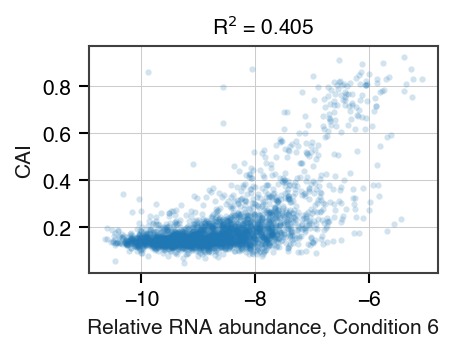

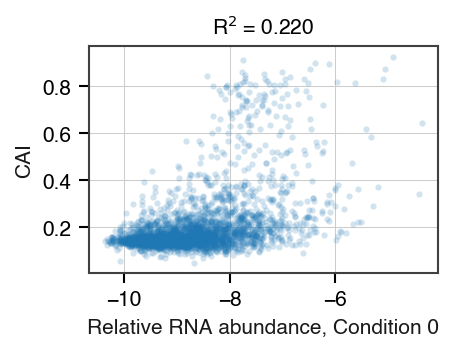

In [45]:
assert all(temp_df.index == full_df.index)
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(temp_df[max_col[1]], full_df[metric], marker='.', linestyle='', alpha=0.2)
if 'ecoli' in data_tag:
    ax.set_xlabel('Expression in Condition {} (TPM)'.format(max_col[0]))
elif data_tag == 'scer_rna':
    ax.set_xlabel('Relative RNA abundance, Condition {}'.format(max_col[0]))
elif data_tag == 'scer_prot':
    ax.set_xlabel('Relative protein abundance, Condition {}'.format(max_col[0]))
ax.set_ylabel(metric)
ax.set_title(r"R$^2$ = {:.3f}".format(max_r2))
if save_figs:
    plt.savefig(figs_dir+'/{}_vs_Cond{}.pdf'.format(metric, max_col[0]), bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3,2))
ax.plot(temp_df[min_col[1]], full_df[metric], marker='.', linestyle='', alpha=0.2)
if 'ecoli' in data_tag:
    ax.set_xlabel('Expression in Condition {} (TPM)'.format(min_col[0]))
elif data_tag == 'scer_rna':
    ax.set_xlabel('Relative RNA abundance, Condition {}'.format(min_col[0]))
elif data_tag == 'scer_prot':
    ax.set_xlabel('Relative protein abundance, Condition {}'.format(min_col[0]))
ax.set_ylabel(metric)
ax.set_title(r"R$^2$ = {:.3f}".format(min_r2))
if save_figs:
    plt.savefig(figs_dir+'/{}_vs_Cond{}.pdf'.format(metric, min_col[0]), bbox_inches='tight')

SpearmanrResult(correlation=0.4674602320616079, pvalue=0.009196960306485799)
(0.48397140444358033, 0.00673194055090414)


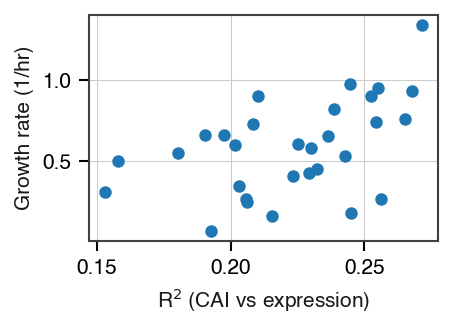

In [34]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(corrs, growth, marker='o', linestyle='')
ax.set_xlabel('R$^2$ ({} vs expression)'.format(metric))
ax.set_ylabel('Growth rate (1/hr)')
print(stats.spearmanr(corrs, growth))
print(stats.pearsonr(corrs, growth))
ax.set_title('')
if save_figs:
    plt.savefig(figs_dir+'/growth_vs_cond_corrs.pdf', bbox_inches='tight')

# Determine which expression-based summary statistics are *most* correlated with CUB metrics

In [17]:
print(full_df.columns)

Index(['gene', 'start_loc', 'stop_loc', 'strand', 'cds_seq', 'cds_len',
       'well_behaved', 'GC_percent_cds', 'roc_semppr_mean', 'iCUB', 'CAI',
       'tAI', 'count', 'mean', 'std', 'min', '25_percentile', '50_percentile',
       '75_percentile', 'max', 'cv', 'noise', 'lin_slope', 'lin_r',
       'spearmans_rho'],
      dtype='object')


In [18]:
sstats = ['mean', '50_percentile', 'max', 'min']

cub_corrs = []
for sstat in sstats:
    r, p = stats.pearsonr(full_df[metric], full_df[sstat])
    r2 = r**2
    print(sstat, r2, p)
    cub_corrs.append(r2)

other_metrics = ['GC_percent_cds', 'cds_len']
other_corrs = []
for other_metric in other_metrics:
    r, p = stats.pearsonr(full_df[other_metric], full_df[sstat])
    r2 = r**2
    print(other_metric, r2, p)
    other_corrs.append(r2)

mean 0.26894306928352224 6.926386940296424e-264
50_percentile 0.25570908044893487 6.770845505554565e-249
max 0.2544825004190619 1.6088149504169594e-247
min 0.23534982746899752 2.4013536098863037e-226
GC_percent_cds 0.03548840742962816 4.597065924386858e-32
cds_len 0.0027982551079439415 0.0010299300121771472


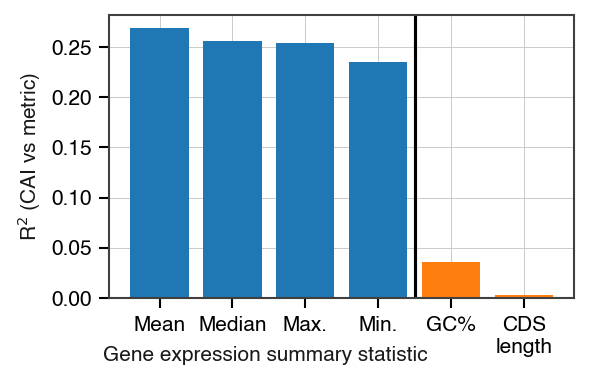

In [19]:
fig, ax = plt.subplots(figsize=(4,2.5))
ax.bar(np.arange(len(cub_corrs)), cub_corrs)
ax.set_ylabel('R$^2$ ({} vs metric)'.format(metric))


ax.axvline(len(cub_corrs)-0.5, c='k')
ax.bar(np.arange(len(cub_corrs), len(cub_corrs)+len(other_corrs)), other_corrs)

ax.set_xticks(np.arange(len(cub_corrs) + len(other_corrs)))
ax.set_xticklabels(['Mean', 'Median', 'Max.', 'Min.', 'GC%', 'CDS\nlength'], rotation=0)
ax.set_xlabel('Gene expression summary statistic', labelpad=(0, 10, 0, 0))
ax.xaxis.set_label_coords(0.335, -0.17)



if save_figs:
    plt.savefig(figs_dir+'/{}_summary_stats_corr.pdf'.format(metric), bbox_inches='tight')

## Hair-brained scheme to optimize weights

(shelved for now, lots of parameters to optimize and a strange fitness landscape to consider)

In [ ]:
# def custom_corr_fxn(weights, exp_df, full_df):
#     all_vals = []
#     for gene in full_df.index:
#         all_vals.append(np.average(exp_df.loc[gene], weights=weights))
#     rho, p = stats.spearmanr(all_vals, full_df['CAI'])
#     print('here {}'.format(rho))
#     return (1-rho)

In [ ]:
# x0 = np.random.random(size=len(exp_df.columns))
# x0 = x0 / np.sum(x0)
# print(np.sum(x0))
# constraints = [{'type': 'eq', 'fun': lambda x: 1 - sum(x)},
#                {'type': 'ineq', 'fun': lambda x: x}]

# res = minimize(custom_corr_fxn, x0, args=(exp_df, full_df), method='SLSQP', constraints=constraints,
#                options={'maxiter': 20, 'disp': True, 'eps':1e-1})

In [ ]:
# bounds = [(0,1) for i in exp_df.columns]
# def constr_f(x):
#     return np.sum(x)
# nlc = NonlinearConstraint(constr_f, 1.0, 1.0)

# res = differential_evolution(custom_corr_fxn,\
#                              bounds=np.array(bounds),\
#                              args=(exp_df, full_df),\
#                              constraints=[nlc])

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(res.x, meta_df['Growth Rate (1/hr)'])

# Regression analysis to assess predictors of CUB

In [ ]:
print(full_df.columns)

In [ ]:
model_correlations = []

In [ ]:
###Model 1, average expression
model1_params = []
fitted = smf.ols('zscore({}) ~ zscore(mean)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model_correlations.append(fitted.rsquared_adj)
model1_params = list(zip(params, cis.values))
fitted.summary()

In [ ]:
###Model 2, growth correlation
model2_params = []
fitted = smf.ols('zscore({}) ~ zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model2_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)


fitted.summary()

In [ ]:
###Model 3, all together
model3_params = []
fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model3_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)
fitted.summary()

In [ ]:
counter = 0
fig, ax = plt.subplots()
for model_params in [model1_params, model2_params, model3_params]:
    for i,ind_param in enumerate(model_params[1:]):
        plt.plot(ind_param[0], -i+counter, marker='s', markersize=8, color=color_cycle[0])
        plt.plot([ind_param[1][0], ind_param[1][1]], [-i+counter, -i+counter], marker='', color='0.35')
    ax.axhline(-i+counter-1, c='k')
    counter -= 2
ax.set_ylim(-6, 1)
ax.set_yticks(range(-6, 2))
labels_top_to_bottom = ['', 'Expression\n(mean)\t\t', '',\
                    'GAI', '',\
                    'Expression\n(mean)\t\t', 'GAI', '']
ax.set_yticklabels(labels_top_to_bottom[::-1])
ax.set_xlabel('Standardized model coefficient')
ax.set_xlim(0, 0.6)
if save_figs:
    plt.savefig(figs_dir+'/{}_model_comp_coefs.pdf'.format(metric), bbox_inches='tight')

fig, ax = plt.subplots()
ax.barh(0, model_correlations[0], 0.8, facecolor='0.5')
ax.barh(-2, model_correlations[1], 0.8, facecolor='0.5')
ax.barh(-4.5, model_correlations[2], 0.8, facecolor='0.5')
ax.axhline(-1, c='k')
ax.axhline(-3, c='k')
ax.set_ylim(-6, 1)
ax.set_yticks(range(-6, 2))
ax.set_yticklabels([''])
ax.set_xlabel('Adjusted-R$^2$');
if save_figs:
    plt.savefig(figs_dir+'/{}_model_comp_R2.pdf'.format(metric), bbox_inches='tight')

In [ ]:
###Model1
fig, ax = plt.subplots()
ax.plot(full_df['mean'], zscore(full_df[metric]), marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Expression (mean)')
ax.set_ylabel('{} (zscore)'.format(metric))

###Model 2
fig, ax = plt.subplots()
ax.plot(full_df['lin_r'], zscore(full_df[metric]), marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('GAI')
ax.set_ylabel('{} (zscore)'.format(metric))

###Model 3
fig, ax = plt.subplots()
ax.plot(fitted.predict(), zscore(full_df[metric]), marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Multi-variate model predictions')
ax.set_ylabel('{} (zscore)'.format(metric))
if save_figs:
    plt.savefig(figs_dir+'/{}_best_additive.pdf'.format(metric), bbox_inches='tight')

In [ ]:
print(stats.spearmanr(zscore(full_df['mean']), zscore(full_df[metric])))
print(stats.spearmanr(fitted.predict(), zscore(full_df[metric])))

## Robustness check 

**Ensure that results are consistent when using with value from the lowest/highest correlation condition *rather* than the mean**

In [ ]:
temp_df = full_df.merge(exp_df, left_index=True, right_index=True, how='inner')
temp_df.rename(columns={min_col[1]:'min_col',max_col[1]:'max_col'}, inplace=True)

In [ ]:
fitted = smf.ols('zscore({}) ~ zscore({}) + zscore(lin_r)'.format(metric, 'min_col'), data=temp_df).fit()
fitted.summary()

In [ ]:
fitted = smf.ols('zscore({}) ~ zscore({}) + zscore(lin_r)'.format(metric, 'max_col'), data=temp_df).fit()
fitted.summary()

# Visualizing alternative models for robustness

**First, an interaction effect**

In [ ]:
fitted = smf.ols('{} ~ mean * lin_r'.format(metric), data=full_df).fit()
fitted.summary()

In [ ]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*x_vals) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*x_vals*i), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_best_interaction.pdf'.format(metric), bbox_inches='tight')

**Next, a basic polynomial fit**

In [ ]:
fitted = smf.ols('{} ~ np.power(mean, 2) + np.power(mean, 1) + lin_r'.format(metric), data=full_df).fit()
fitted.summary()

In [ ]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*np.power(x_vals, 2)) +\
            (fitted.params[2]*np.power(x_vals, 1)) +\
            (fitted.params[3]*i), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_poly_multi.pdf'.format(metric), bbox_inches='tight')

**And a log-transformed y-variable fit (with the interaction term**

In [ ]:
fitted = smf.ols('np.log({}) ~ mean * lin_r'.format(metric), data=full_df).fit()
fitted.summary()

In [ ]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, np.exp(fitted.params[0] +\
            (fitted.params[1]*x_vals) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*x_vals*i)), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))

# Finally, some mixed linear models

There are a few benefits and a few problems to the following analysis. **If** you're going to discretize data, you should do it using a mixed linear model as opposed to fixed-effects. Here, I'm only *really* interested in dealing with discrete categories as a visual companion, so this framework and the resulting plots have a few nice visual perks. But the above analyses that do not discretize the growth rate variable are far more statistically *correct* in my opinion.

Mixed effect models are difficult to summarize, we don't get the benefit of an R2 anymore (the term doesn't have much meaning here). We also can't directly compare models using the log-transformed response variable directly with the non-log-transformed version. Apparently, the log-likelihoods, AICs, etc. are on different scales and while there appear to be some ways to map one onto the other I haven't dug into this yet. 

There are some nuanced issues with fitting to the log-transformed data since the error distributions make some incorrect assumptions when doing this, but note that doesn't seem to ever stop anyone from log-scaling data and fitting linear lines so I'm putting it out there as a relatively minor issue here.

Also, the `reml` flag seems to be a "choose-as-you-see-fit" parameter. There are a lot of warnings that crop up, but the results even with a bunch of warnings for basic `mixedlm` models look almost the same as the `ols` models so I didn't find this to be too concerning. 

And again, I can't stress this enough that we're doing this mainly for visualization purposes, binning / discretizing continuous data is **always** a bad idea (I've yet to ever see convincing evidence to the contrary). 

In [ ]:
reml=True
n_cats = 10
full_df['growth_cat'] = pd.qcut(full_df['lin_r'], n_cats, labels=list(range(n_cats)))

## Linear model with a fixed slope and random intercept

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Linear with a random slope and fixed intercept

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~0+mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = fitted.params[0] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Linear with random effect slope AND random intercepts

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Exponential with random slopes and random intercepts

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('np.log({}) ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
    line = np.exp(fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals))
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

# Scratch

In [ ]:
full_df

In [ ]:
full_df.hist('lin_r')

In [ ]:
metric = 'CAI'
fitted = smf.ols('zscore({}) ~ zscore(mean)'.format(metric), data=full_df).fit()
fitted.summary()
# fitted = smf.ols('zscore({}) ~ zscore(lin_r)'.format(metric), data=full_df).fit()
# fitted.summary()
# fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(lin_r)'.format(metric), data=full_df).fit()
# fitted.summary()
# fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(GC_percent_cds)'.format(metric), data=full_df).fit()
# fitted.summary()

In [ ]:
fig, ax = plt.subplots()
# ax.plot(full_df['mean'], full_df['CAI'], linestyle='', marker='.')
ax.plot(zscore(full_df['mean']), zscore(full_df['CAI']), linestyle='', marker='.')
# ax.semilogx(full_df['mean'], full_df['CAI'], linestyle='', marker='.')

In [ ]:
full_df['mean'].min()